In [2]:
%load_ext rpy2.ipython

In [3]:
#!gist -p internal_model_combine_lof_and_damaging_both_cc_and_dn.ipynb

In [4]:
%%R
load("/usr/data/Documents/SaveDataFromServer/RSTAN/test_rstan_2016_scz_conditionalCaseControl_bothLoF_damaging.nChain.2.nThin.10.index.2_add_stan2coda.RData")
library("rjags")

by .GlobalEnv when processing object ‘testFit’
Loading required package: coda
Linked to JAGS 3.4.0
Loaded modules: basemod,bugs


## Calculate Bayes Factor

In [5]:
!pwd

/usr/data/Documents/GitHub/HierachicalBayesianproject/Model


In [6]:
%%R
###Calculate Bayes Factor
source("../TADA/TADA.R")
ycase <- data$case_damaging + data$case_lof
ycontrol <- data$case_damaging + data$control_lof
ydn <- data$dn_lof + data$dn_damaging
mutAll <- data$mut_lof + data$mut_damaging

ytotal <- ycase + ycontrol
Ncase <- N$ca
Ncontrol <- N$cn
pH0 <- Ncase/(Ncase + Ncontrol)

bfcc <- function(ycase, ytotal, Ncase, Ncontrol,
                 lower.gamma = 1, upper.gamma = 50,
                 hyperGammaMeanCC = 1.94, hyperBetaCC = 1.98){
  bfH0 <- dbinom(ycase, ytotal, prob = pH0)
  
  
  bfH1 <- apply(cbind(ycase, ytotal), 1, function(x){
    f1 <- function(gamma0)
      dbinom(x[1], x[2], gamma0*Ncase/(gamma0*Ncase + Ncontrol))*dgamma(gamma0, shape = hyperGammaMeanCC*hyperBetaCC,
                                                                        rate = hyperBetaCC)
    return(integrate(f1, lower = lower.gamma, upper = upper.gamma)$value)
  })
  return(bfH1/bfH0)
  
}

bfTempH1 <- apply(cbind(ycase, ytotal), 1, function(x)
  dbinom(x[1], x[2], 1.9*Ncase/(1.9*Ncase + Ncontrol)))
bfTempH0 <- apply(cbind(ycase, ytotal), 1, function(x)
  dbinom(x[1], x[2], pH0))


BFcc <- bfcc(ycase = ycase, ytotal = ytotal, Ncase = N$ca, Ncontrol = N$cn)

BFdn <- bayes.factor.denovo(x = ydn, N = N$dn, mu = mutAll, gamma.mean = 6.8, beta = 1)

BFall <- BFcc*BFdn
cor(BFcc, bfTempH1/bfTempH0)


[1] 0.9683056


###Calculate Bayes Factor for LoF and Damaging separately

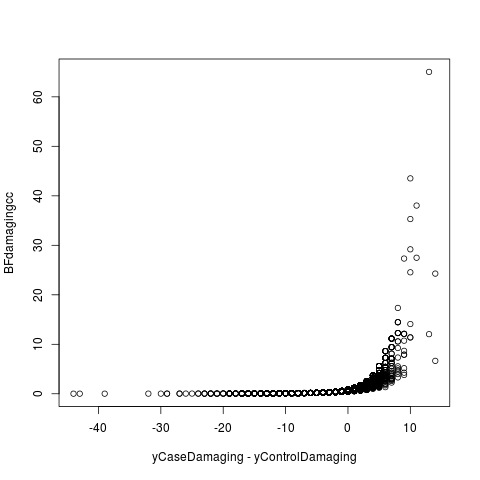

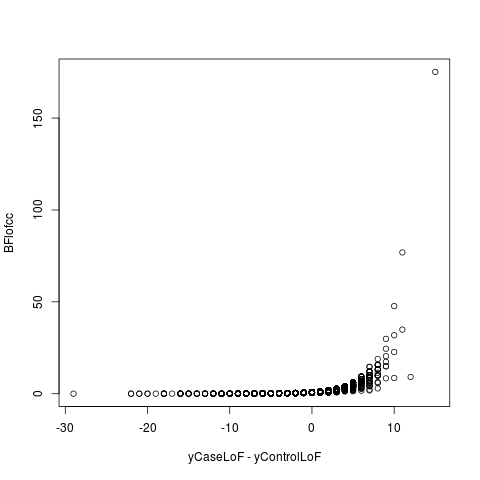

In [12]:
%%R
BFlofcc <- bfcc(ycase = data$case_lof, ytotal = data$case_lof + data$control_lof, 
                Ncase = N$ca, Ncontrol = N$cn,
               hyperGammaMeanCC = 2.15, hyperBetaCC = 1.96)
BFdamagingcc <- bfcc(ycase = data$case_damaging, ytotal = data$case_damaging + data$control_damaging, 
                     Ncase = N$ca, Ncontrol = N$cn,
                    hyperGammaMeanCC = 2.05, hyperBetaCC = 1.85)


BFtotal <- BFlofcc*BFdamagingcc

plot(data$case_lof - data$control_lof, BFlofcc, xlab = 'yCaseLoF - yControlLoF', ylab = 'BFlofcc')
plot(data$case_damaging - data$control_damaging, BFdamagingcc, 
    xlab = 'yCaseDamaging - yControlDamaging', ylab = 'BFdamagingcc')


      Gene      mut_lof mut_missense dn_damaging dn_lof control_damaging
8826 KDM2B 3.502739e-06 5.648129e-05           0      0                6
     case_damaging control_lof case_lof mut_damaging       BF     qvalue
8826            19           1        2  1.09296e-05 73.86032 0.07678266


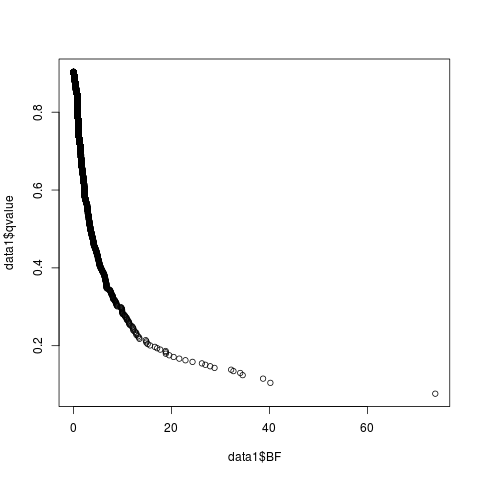

In [17]:
%%R
data$BF <- BFtotal
data1 <- data[order(-data$BF),]
pi0 <- 1 - 0.14
data1$qvalue <- Bayesian.FDR(data1$BF, pi0)$FDR
plot(data1$BF, data1$qvalue)

data2 <- (data1[data1$qvalue < 0.1, ])

data2

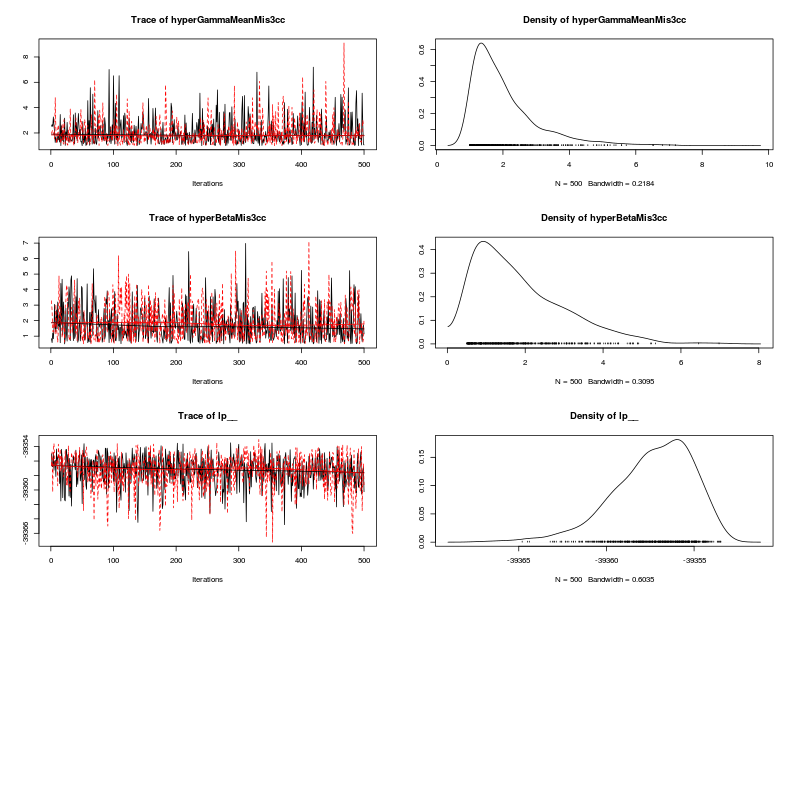

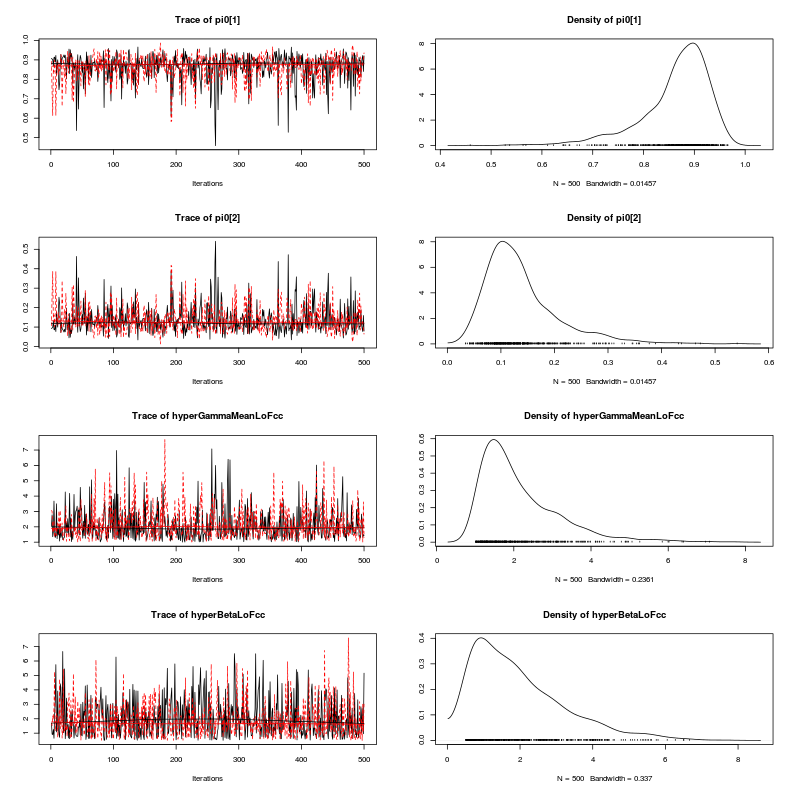

In [18]:
%%R -w 28 -h 28 -u cm
library("coda")
plot(s)

In [19]:
%%R
summary(s)


Iterations = 1:500
Thinning interval = 1 
Number of chains = 2 
Sample size per chain = 500 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

                           Mean     SD Naive SE Time-series SE
pi0[1]                8.625e-01 0.0694 0.002195       0.002427
pi0[2]                1.375e-01 0.0694 0.002195       0.002427
hyperGammaMeanLoFcc   2.146e+00 1.0221 0.032322       0.032313
hyperBetaLoFcc        1.959e+00 1.2659 0.040030       0.039954
hyperGammaMeanMis3cc  2.046e+00 1.0393 0.032866       0.031051
hyperBetaMis3cc       1.851e+00 1.1624 0.036759       0.036712
lp__                 -3.936e+04 2.2724 0.071859       0.082931

2. Quantiles for each variable:

                           2.5%        25%        50%        75%      97.5%
pi0[1]                6.799e-01  8.353e-01  8.779e-01  9.086e-01  9.523e-01
pi0[2]                4.768e-02  9.139e-02  1.221e-01  1.647e-01  3.201e-01
hyperGammaMeanLoFcc   1.048e+00  1.414e+00

In [24]:
%%R
data3 <- (data1[data1$qvalue < 0.3, ])

In [27]:
%%R
c1 <- data3$case_lof - data3$control_lof
c2 <- data3$case_damaging - data3$control_damaging

cbind(c1, c2)

      c1 c2
 [1,]  1 13
 [2,]  6  6
 [3,]  0 10
 [4,]  1 11
 [5,] 15 -5
 [6,]  4  9
 [7,]  6  5
 [8,]  0 10
 [9,]  7  5
[10,]  0 11
[11,]  7  3
[12,]  0  9
[13,]  9  1
[14,]  0 14
[15,] 11 -1
[16,]  2  9
[17,]  3  7
[18,]  8  1
[19,]  6  7
[20,]  1 10
[21,]  2  7
[22,]  9  2
[23,]  2  6
[24,]  5  3
[25,]  3  9
[26,]  9  0
[27,]  6  5
[28,]  8  0
[29,]  7  2
[30,]  6  5
[31,]  0  8
[32,] 11 -6
[33,]  9  0
[34,]  7  0
[35,]  9 -1
[36,]  7  1
[37,]  7  1
[38,]  7  6
[39,]  5  5
[40,] 10 -2
[41,]  7  2
[42,]  8  0
[43,]  8  0
[44,]  2  6
[45,]  3  6
[46,]  6 14
[47,]  0  8
[48,]  5  3
[49,]  1  6
[50,] 10 -4
[51,]  4  6
[52,]  8  0
[53,] -2 10
[54,]  5  2
[55,]  4  5
[56,]  7  1
[57,]  8  1
[58,]  4  3
[59,]  0  7
[60,]  0  7
[61,]  0  7
[62,]  0  7
[63,]  3  4
[64,]  4  4
[65,]  8  0
[66,]  3  5
[67,]  7  0


In [28]:
%%R
geneName <- as.character(data3$Gene)

geneName

 [1] "KDM2B"     "STXBP2"    "BECN1"     "ECSIT"     "ALDH1L2"   "KDM5B"    
 [7] "MSH3"      "MOCS2"     "ETFB"      "TLR2"      "SBSN"      "KIAA0930" 
[13] "SLC35B2"   "GLI2"      "MAZ"       "PDE4C"     "COG1"      "ZMYM2"    
[19] "ATP9B"     "LMTK2"     "SNCG"      "AGXT2"     "KLHL35"    "MRPS28"   
[25] "ATP2A1"    "KIR2DL3"   "ROBO1"     "ZNF211"    "C2orf47"   "PRMT7"    
[31] "GCM2"      "LNX1"      "ZNF442"    "PILRA"     "SLC25A10"  "UBOX5"    
[37] "UBOX5-AS1" "IARS"      "CSPP1"     "ITFG3"     "ERAP2"     "HLA-A"    
[43] "KANK3"     "ARHGAP25"  "NIT1"      "DNAH3"     "BCR"       "LIFR"     
[49] "MTMR10"    "TCIRG1"    "PET112"    "TYW5"      "ARFGEF1"   "AK7"      
[55] "LRIT3"     "CPVL"      "BCCIP"     "SNAPC2"    "CYB561D1"  "EHMT1"    
[61] "PLS3"      "WNT8B"     "DPY19L2"   "GEN1"      "ZNF417"    "PRKD3"    
[67] "SP1"      


In [37]:
%%R
geneFMRP <- read.table("/usr/data/Documents/GitHub/NewTestR/TestR/HBproject/extTADA/scripts/autism.data.fromTADApackage.geneset.FMRP.txt",
                      stringsAsFactors = FALSE, header = TRUE)

In [38]:
%%R
geneNameFMRP <- as.character(geneFMRP$Gene)

In [40]:
%%R
pmatch(geneName, geneNameFMRP)

 [1]  NA  NA  NA  NA  NA  NA  NA  NA  NA  NA  NA  NA  NA  NA 378  NA  NA  NA  NA
[20] 346  NA  NA  NA  NA  NA  NA  NA  NA  NA  NA  NA  NA  NA  NA  NA  NA  NA  NA
[39]  NA  NA  NA  NA  NA  NA  NA  NA  99  NA  NA  NA  NA  NA  52  NA  NA  NA  NA
[58]  NA  NA 223  NA  NA  NA  NA  NA  NA  NA
